In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from utils import (read_10x_visium, data_augmentation, search_res, construction_interaction, fix_seed,
                   add_contrastive_label, get_feature, preprocess_adj)
from model import AutoEncoder
from image_feature import ImageFeature, image_crop
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
section = '151673'
data_path = 'D:/st_projects/data/DLPFC'
# load 10 X DLPFC dataset as benchmark
adata = read_10x_visium(path=os.path.join(data_path, section), count_file=section + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.obs['ground_truth'] = pd.read_csv(os.path.join(data_path, section) + '/' + section + '_truth.txt', sep='\t', header=None, index_col=0)

cluster_num = pd.get_dummies(adata.obs['ground_truth']).shape[1]
cluster_num

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


7

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
adata

View of AnnData object with n_obs × n_vars = 3639 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'ground_truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata.raw = adata

In [5]:
# Motivation
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)

sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
# sc.pp.scale(adata)

In [6]:
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]  


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 3639 × 11353
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'ground_truth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

In [7]:
# 在使用形态学特征，给空间0-1近邻图的边进行赋权

from sklearn.metrics import pairwise_distances
construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity

In [8]:
position = adata.obsm['spatial'].copy()
position[:, 1] = -position[:, 1]

Maximum weight: 1.0


(2697.7, 11460.3, -12041.35, -1979.65)

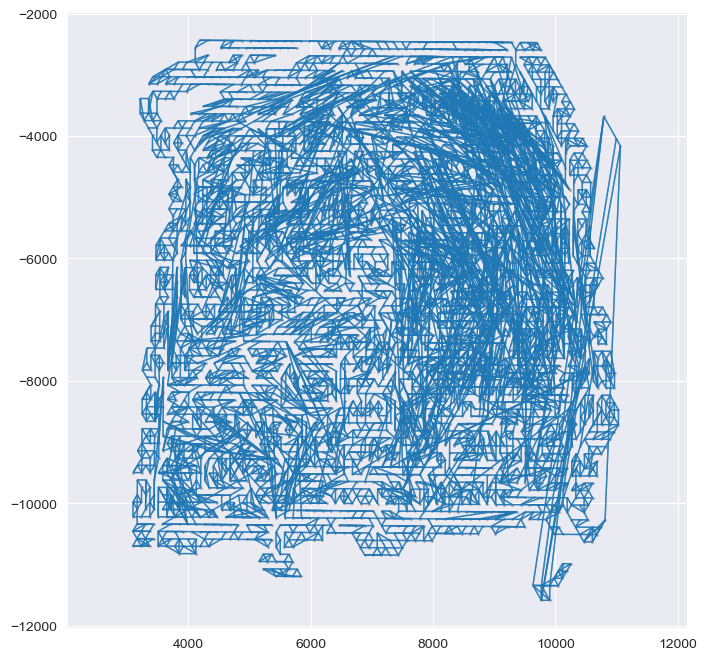

In [9]:
# 在整个组织图背景下，绘制近邻网络结构图
from utils import plot_graph_weights
from scipy import sparse
import matplotlib.pyplot as plt

interaction = np.zeros_like(morphological_similarity)
for i in range(morphological_similarity.shape[0]):
    vec = morphological_similarity[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(1, 3 + 1):
        y = distance[t]
        interaction[i, y] = 1
    
interaction = interaction + interaction.T
interaction = np.where(interaction > 1, 1, interaction)

plot_graph_weights(position, sparse.csr_matrix(interaction), max_weight=1, markersize=1, figsize=(8, 8))
ax = plt.gca()
ax.axis('equal')

In [10]:
# 数据增广
from scipy.sparse import csr_matrix

if isinstance(adata.X, csr_matrix):
    gene_matrix = adata.X.A
elif isinstance(adata.X, np.ndarray):
    gene_matrix = adata.X
elif isinstance(adata.X, pd.DataFrame):
    gene_matrix = adata.X.values
else:
    raise ValueError(f"{type(adata.X)} is not a valid type here")

# 各个Spot对当前Spot归一化后的权重
weights_list = []
final_coordinates = []

for i in range(adata.shape[0]):
    current_spot = adj_spatial_mor[i].argsort()[-6: ][: -1]
    spot_weight = adj_spatial_mor[i][current_spot]
    spot_feature_matrix = gene_matrix[current_spot]
    if spot_weight.sum() != 0:
        spot_weight_scaled = spot_weight / spot_weight.sum()
        weights_list.append(spot_weight_scaled)
        spot_matrix_scaled = np.multiply(spot_weight_scaled.reshape(-1, 1), spot_feature_matrix)
        spot_matrix_final = np.sum(spot_matrix_scaled, axis=0)
        final_coordinates.append(spot_matrix_final)
    else:
        print(i, current_spot)
        final_coordinates.append(gene_matrix[i])

In [11]:
adjacent_spot_data = np.array(final_coordinates)
adjacent_weight = 0.3

if isinstance(adata.X, np.ndarray):
    augment_gene_matrix = adata.X + adjacent_weight * adjacent_spot_data.astype(float)
elif isinstance(adata.X, csr_matrix):
    augment_gene_matrix = adata.X.A + adjacent_weight * adjacent_spot_data.astype(float)
    
augment_gene_matrix.shape

(3639, 11353)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [13]:
adata.obsm['augment_gene_data'] = augment_gene_matrix
# adata.obsm['augment_gene_data'] = adata.X

In [14]:
add_contrastive_label(adata)
get_feature(adata)

features = torch.FloatTensor(adata.obsm['feat'].copy()).to(device)
features_fake = torch.FloatTensor(adata.obsm['feat_fake'].copy()).to(device)
label_CSL = torch.FloatTensor(adata.obsm['label_CSL']).to(device)

In [19]:
from torchtoolbox.tools import mixup_criterion
from loss import Objective
from model import OurModel

dim_input = features.shape[1]
dim_output = 32

adj = preprocess_adj(adj_spatial_mor)
adj = torch.FloatTensor(adj).to(device)

image_feature = torch.FloatTensor(adata.obsm['image_feature']).to(device)
aug_image_feature1 = torch.FloatTensor(adata.obsm['aug_image_feature1']).to(device)
aug_image_feature2 = torch.FloatTensor(adata.obsm['aug_image_feature2']).to(device)


model = OurModel(gene_dims=[adata.shape[1], 64], img_dims=[adata.obsm['image_feature'].shape[1], 64], graph_nei=adj, project_dims=[64, dim_output]).to(device)

loss_CSL = nn.BCEWithLogitsLoss()
loss_cont = Objective(batch_size=adata.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.)
print('Begin to train ST data...')

lamb1 = 0.2
lamb2 = 0.1
gamma = 1
lamb3 = 0.2

model.train()
pre_epoch = 1500
cont_epoch = 200
if lamb1 == 0:
    total_epoch = pre_epoch
else:
    total_epoch = pre_epoch + cont_epoch

epoch_iter = tqdm(range(total_epoch))
for epoch in epoch_iter:
    # zg, zi, aug_zi, hg, hi, aug_hi, dis_a, dis_b, rec_gene
    latent_gene, latent_img, latent_aug_img1, latent_aug_img2, high_gene, high_img, high_aug_img1, high_aug_img2, ret, ret_fake, rec_data, rec_img = model.forward(features, features_fake, image_feature, aug_image_feature1, aug_image_feature2, adj)
    loss_sl_1 = loss_CSL(ret, label_CSL)
    loss_sl_2 = loss_CSL(ret_fake, label_CSL)
    loss_g2g = loss_sl_1 + loss_sl_2

    loss_feat = F.mse_loss(features, rec_data)
    loss_img = F.mse_loss(image_feature, rec_img)
    
    loss_recon = loss_feat + lamb1 * loss_img
    if epoch < pre_epoch:
        loss = loss_recon + lamb2 * loss_g2g
    else:
        loss_i2i = loss_cont(high_aug_img1, high_aug_img2)
        lam = np.random.beta(0.2, 0.2)
        loss_i2g = mixup_criterion(loss_cont, high_gene, high_img, high_aug_img1, lam)
        loss = loss_recon + lamb2 * loss_g2g + gamma * loss_i2i + lamb3 * loss_i2g
        
    if epoch == pre_epoch:
        print(f"# Epoch {epoch}, loss: {loss.item():.3f}, g2g_loss: {loss_g2g.item():.3f}, gene_recon: {loss_feat.item():.3f}, image_recon: {loss_img.item():.3f}")
        print('Init finished, start contrastive learning part')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch < pre_epoch:
        epoch_iter.set_description(
        f"# Epoch {epoch}, loss: {loss.item():.3f}, g2g_loss: {loss_g2g.item():.3f}, gene_recon: {loss_feat.item():.3f}, image_recon: {loss_img.item():.3f}")
    else:
        epoch_iter.set_description(
        f"# Epoch {epoch}, loss: {loss.item():.3f}, g2i_loss: {loss_i2g.item():.3f}, g2g_loss: {loss_g2g.item():.3f}, i2i_loss: {loss_i2i.item():.3f}, gene_recon: {loss_feat.item():.3f}, image_recon: {loss_img.item():.3f}")
print('Optimization finished for ST data!')

Begin to train ST data...


# Epoch 1499, loss: 1.022, g2g_loss: 0.522, gene_recon: 0.969, image_recon: 0.004:  88%|████████▊ | 1498/1700 [00:29<00:03, 50.62it/s]

# Epoch 1500, loss: 95.329, g2g_loss: 0.521, gene_recon: 0.969, image_recon: 0.004
Init finished, start contrastive learning part


# Epoch 1699, loss: 11.740, g2i_loss: 8.921, g2g_loss: 1.227, i2i_loss: 8.854, gene_recon: 0.977, image_recon: 0.008: 100%|██████████| 1700/1700 [05:02<00:00,  5.61it/s]  

Optimization finished for ST data!


In [20]:
with torch.no_grad():
    model.eval()
    latent_gene, latent_img, latent_aug_img1, latent_aug_img2, high_gene, high_img, high_aug_img1, high_aug_img2, ret, ret_fake, rec_data, rec_img = model.forward(features, features_fake, image_feature, aug_image_feature1, aug_image_feature1, adj)
    latent_gene = latent_gene.detach().cpu().numpy()
    latent_img = latent_img.detach().cpu().numpy()
    rec_data = rec_data.detach().cpu().numpy()
    rec_img = rec_img.detach().cpu().numpy()

In [21]:
from sklearn.decomposition import PCA

adata.obsm['rec_feature'] = rec_data
adata.layers['My_ReX'] = rec_data

alpha = lamb1
pca = PCA(n_components=20, random_state=2023)
rec_feat_pca = pca.fit_transform(rec_data)
rec_img_pca = pca.fit_transform(rec_img)
adata.obsm['rec_feat_pca'] = rec_feat_pca
adata.obsm['rec_img_pca'] = rec_img_pca
adata.obsm['fusion_pca'] = rec_feat_pca + alpha * rec_img_pca
rec_data.shape, rec_feat_pca.shape, rec_img_pca.shape

((3639, 11353), (3639, 20), (3639, 20))

fitting ...
  |======================================================================| 100%


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.C

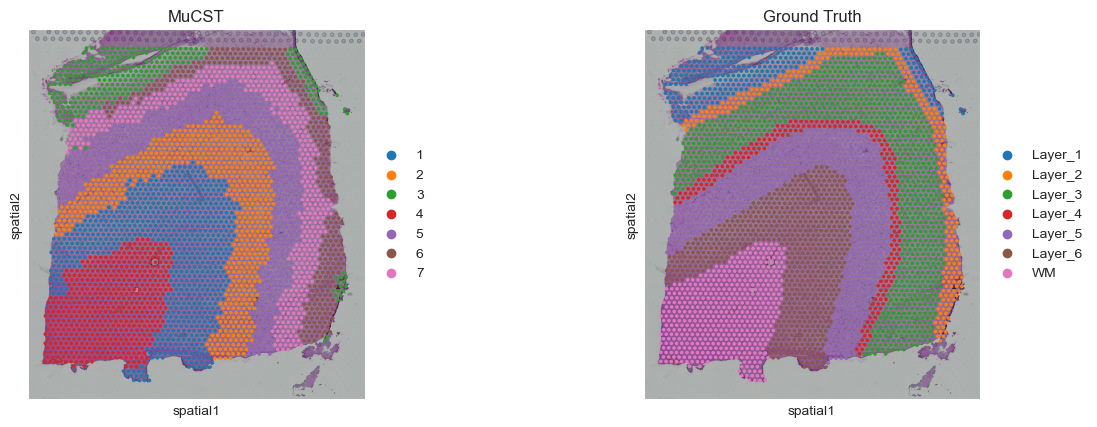

In [24]:
from utils import mclust_R, refine_label
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

from utils import clustering
tool = 'mclust'
radius = 10

mclust_R(adata, used_obsm='fusion_pca', num_cluster=cluster_num)

new_type = refine_label(adata, radius, key='mclust')
adata.obs['domain'] = new_type

adata_full = adata[~pd.isnull(adata.obs['ground_truth'])]
# print(adjusted_rand_score(adata_full.obs['domain'], adata_full.obs['ground_truth']))

sc.pl.spatial(adata_full, color=['domain', 'ground_truth'], title=['MuCST', 'Ground Truth'])

In [34]:
from scipy import stats

data_group1 = adata[adata.obs['ground_truth'] == 'WM'].obsm['rec_feature'].mean(0)
data_group2 = adata[adata.obs['ground_truth'] == 'Layer_6'].obsm['rec_feature'].mean(0)
# 单边t检验; 双边就设置alternative='less'即可
t_statistic, p_value = stats.ttest_ind(data_group1, data_group2, alternative='greater')

# 输出检验结果
print("T statistic:", t_statistic)
print("P value:", p_value)

T statistic: 2.580285166821788
P value: 0.004939048493752646


In [250]:
# 将gene的exp缩放到0-1之间，并绘制in, out, raw, rec的boxplot
def relative_func(expres):
    #expres: an array counts expression for a gene
    maxd = np.max(expres) - np.min(expres)
    min_exp = np.min(expres)
    rexpr = (expres - min_exp) / maxd
    return rexpr

In [251]:
raw_exp = adata.X.A
raw_exp = pd.DataFrame(raw_exp)
rec_exp = pd.DataFrame(adata.obsm['rec_feature'])

raw_exp.index = adata.obs.index
raw_exp.columns = adata.var.index
rec_exp.index = adata.obs.index
rec_exp.columns = adata.var.index

In [159]:
adata.obs['ground_truth']

AAACAAGTATCTCCCA-1    Layer_3
AAACAATCTACTAGCA-1    Layer_1
AAACACCAATAACTGC-1         WM
AAACAGAGCGACTCCT-1    Layer_3
AAACAGCTTTCAGAAG-1    Layer_5
                       ...   
TTGTTTCACATCCAGG-1         WM
TTGTTTCATTAGTCTA-1         WM
TTGTTTCCATACAACT-1    Layer_6
TTGTTTGTATTACACG-1         WM
TTGTTTGTGTAAATTC-1    Layer_2
Name: ground_truth, Length: 3639, dtype: category
Categories (7, object): ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupb

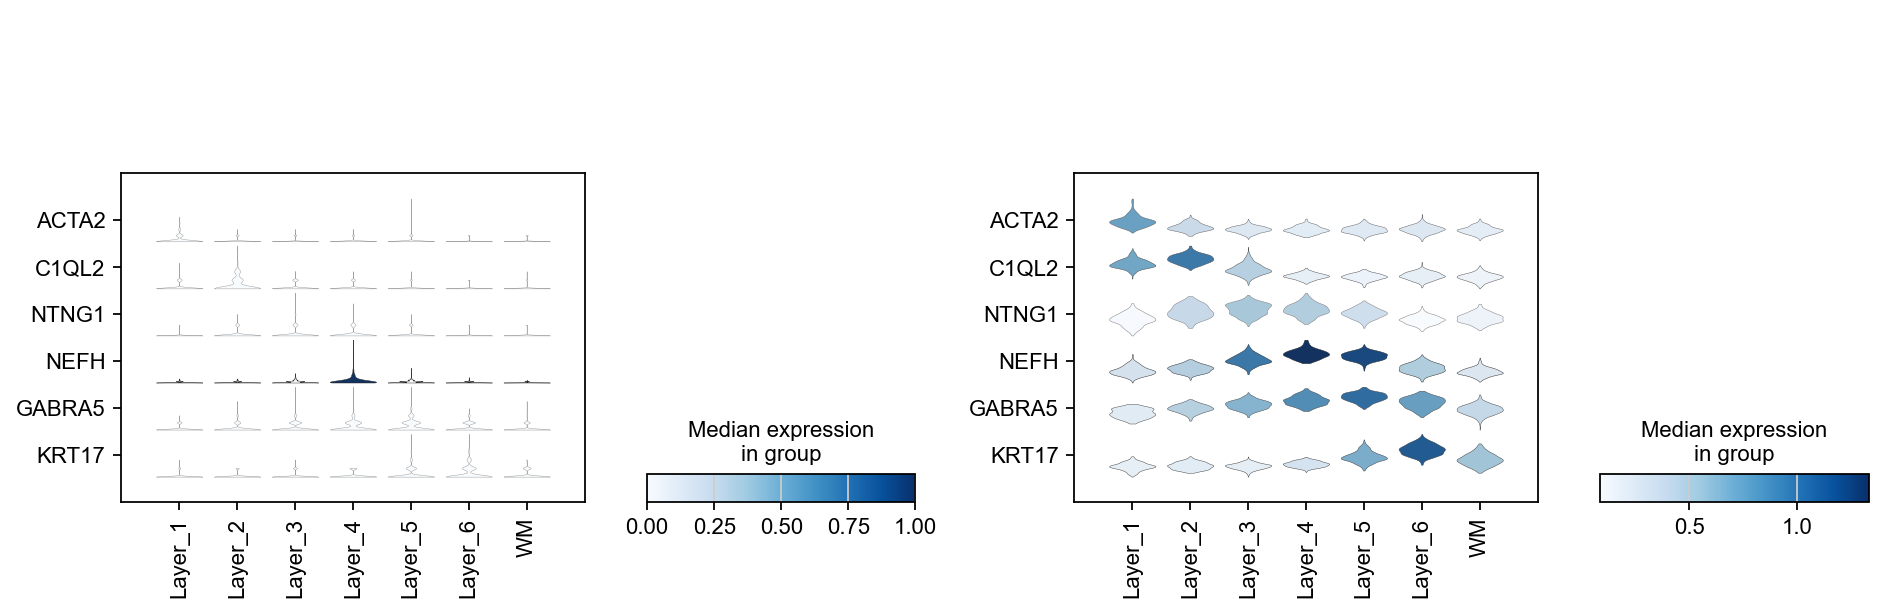

In [253]:
plot_gene = ['KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2'][::-1]
# marker_genes = ['S100B', 'KRT17', 'GABRA5', 'NEFH', 'NTNG1', 'C1QL2', 'ACTA2' ]
# marker_genes = marker_genes[::-1]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', swap_axes=True, ax=axs[0], show=False)
sc.pl.stacked_violin(adata, var_names=plot_gene, groupby='ground_truth', layer='My_ReX', swap_axes=True, ax=axs[1], show=False)
plt.savefig('images/dlpfc_raw_enhance_gene_stacked_violin.eps', dpi=300, format='eps')
plt.show()